In [50]:
import torch
import os
from PIL import Image, ImageDraw, ImageFont
import requests
import copy
import numpy as np
%matplotlib inline

In [2]:
# Running on cpu
from unittest.mock import patch
from transformers.dynamic_module_utils import get_imports

def fixed_get_imports(filename: str | os.PathLike) -> list[str]:
    if not str(filename).endswith("modeling_florence2.py"):
        return get_imports(filename)
    imports = get_imports(filename)
    imports.remove("flash_attn")
    return imports

In [3]:
from transformers import AutoProcessor, AutoModelForCausalLM

model_id = 'microsoft/Florence-2-base'
with patch("transformers.dynamic_module_utils.get_imports", fixed_get_imports): #workaround for unnecessary flash_attn requirement
    model = AutoModelForCausalLM.from_pretrained(model_id, attn_implementation="sdpa",trust_remote_code=True)
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/Users/prthamesh/personal-projects/dl-learning/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
def run_example(image, task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [21]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

In [64]:
two_people = Image.open('/Users/prthamesh/personal-projects/dl-learning/viva-magenta/img1.jpg')
print(run_example(two_people, '<DETAILED_CAPTION>'))

KeyError: '<OD>'

{'<DETAILED_CAPTION>': 'The image shows a woman\'s face with a red background and a red flower in the middle. On the right side of the image, there is text that reads "Pantone Color of the Year 2020". The woman has a mysterious expression on her face, and her hair is pulled back in a bun. The flower is a vibrant red, adding a pop of color to the image.'}


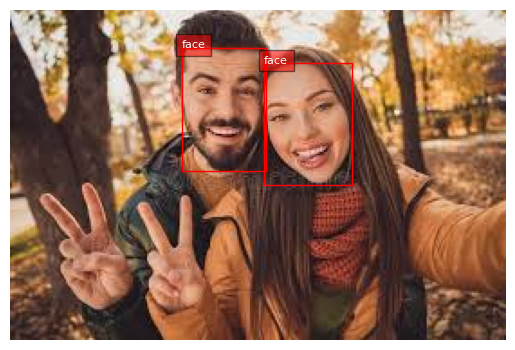

In [34]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(two_people, task_prompt, text_input="face")
plot_bbox(two_people, results['<CAPTION_TO_PHRASE_GROUNDING>'])

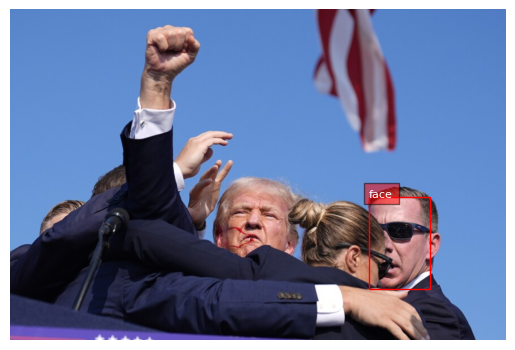

In [35]:
donald_trump = Image.open('/Users/prthamesh/personal-projects/dl-learning/samples/donald-trump-rally.jpeg')
results = run_example(donald_trump, '<CAPTION_TO_PHRASE_GROUNDING>', text_input="face")
plot_bbox(donald_trump, results['<CAPTION_TO_PHRASE_GROUNDING>'])


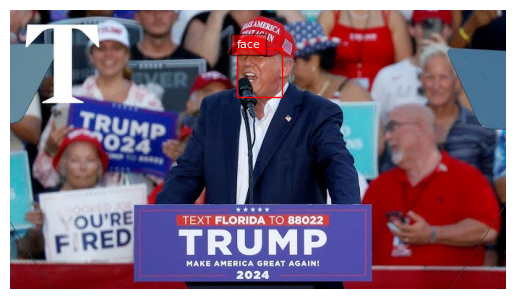

In [36]:
donald_trump_single = Image.open('/Users/prthamesh/personal-projects/dl-learning/samples/donald-trump-single.jpg')
results = run_example(donald_trump_single, '<CAPTION_TO_PHRASE_GROUNDING>', text_input="face")
plot_bbox(donald_trump_single, results['<CAPTION_TO_PHRASE_GROUNDING>'])

In [38]:
def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

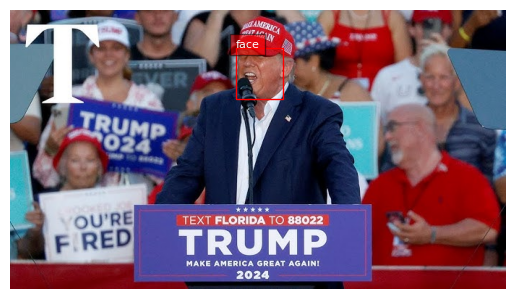

In [39]:
# replace CAPTION_TO_PHRASE_GROUNDING with OPEN_VOCABULARY_DETECTION
results = run_example(donald_trump_single, '<OPEN_VOCABULARY_DETECTION>', text_input="face")
bbox_data = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])
plot_bbox(donald_trump_single, bbox_data)

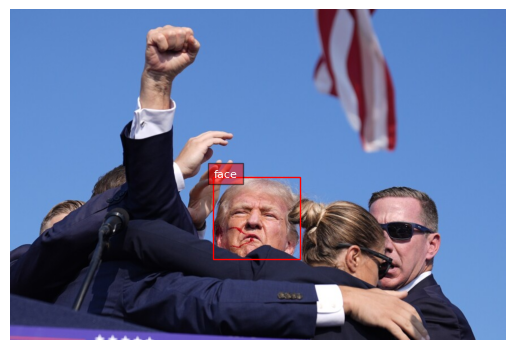

In [40]:
# add for all images
results = run_example(donald_trump, '<OPEN_VOCABULARY_DETECTION>', text_input="face")
bbox_data = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])
plot_bbox(donald_trump, bbox_data)

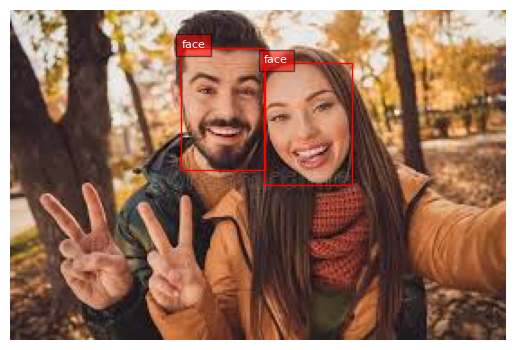

In [41]:
results = run_example(two_people, '<OPEN_VOCABULARY_DETECTION>', text_input="face")
bbox_data = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])
plot_bbox(two_people, bbox_data)

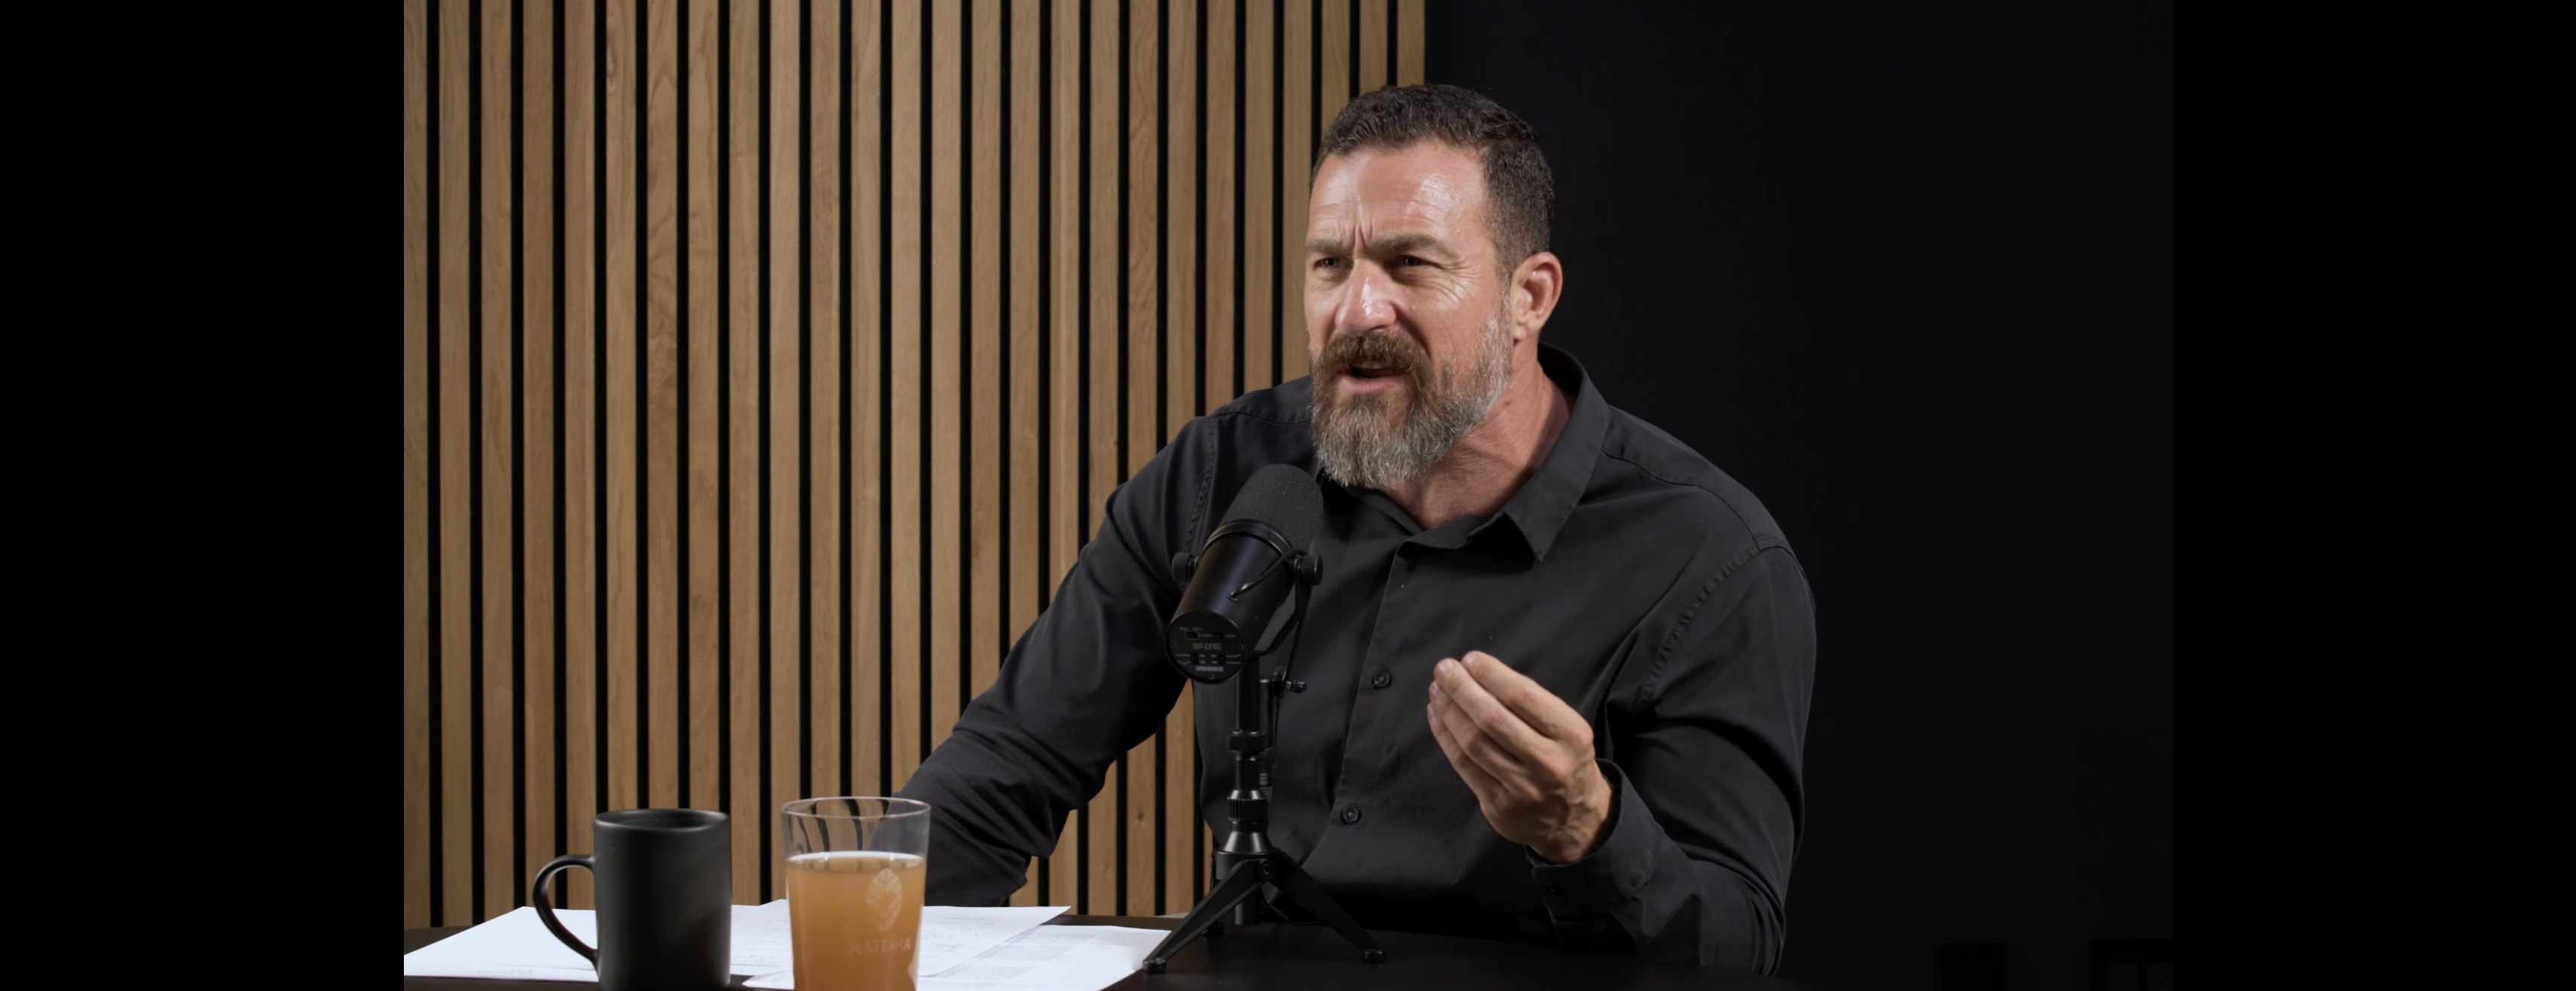

In [82]:
huberman = Image.open('/Users/prthamesh/personal-projects/dl-learning/samples/huberman-3.png')
huberman

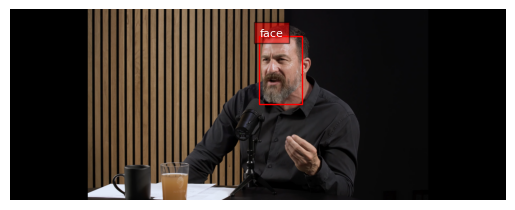

In [83]:
huberman = huberman.convert('RGB')
results = run_example(huberman, '<OPEN_VOCABULARY_DETECTION>', text_input="face")
bbox_data = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])
plot_bbox(huberman, bbox_data)

In [51]:
import random
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)

In [91]:
magenta_1 = Image.open('/Users/prthamesh/personal-projects/dl-learning/samples/magenta-1.jpg')
results = run_example(magenta_1, '<OCR>')
print(results)


{'<OCR>': 'Color ofthe Year2023PANTONE®Viva Magenta18-1750'}


In [92]:
magenta_1 = Image.open('/Users/prthamesh/personal-projects/dl-learning/samples/magenta-1.jpg')
results = run_example(magenta_1, '<OCR_WITH_REGION>')
print(results)


{'<OCR_WITH_REGION>': {'quad_boxes': [[559.6000366210938, 310.4725036621094, 601.2000122070312, 310.4725036621094, 601.2000122070312, 320.5994873046875, 559.6000366210938, 320.5994873046875], [559.6000366210938, 321.6654968261719, 601.2000122070312, 321.6654968261719, 601.2000122070312, 330.72650146484375, 559.6000366210938, 330.72650146484375], [559.6000366210938, 331.79248046875, 586.7999877929688, 331.79248046875, 586.7999877929688, 341.91949462890625, 559.6000366210938, 341.91949462890625], [559.6000366210938, 360.5744934082031, 625.2000122070312, 360.5744934082031, 625.2000122070312, 373.3664855957031, 559.6000366210938, 373.3664855957031], [552.4000244140625, 388.2904968261719, 623.6000366210938, 389.35650634765625, 623.6000366210938, 400.54949951171875, 552.4000244140625, 399.4834899902344], [552.4000244140625, 402.14849853515625, 590.7999877929688, 402.14849853515625, 590.7999877929688, 413.34149169921875, 552.4000244140625, 413.34149169921875]], 'labels': ['</s>Color of', 'the

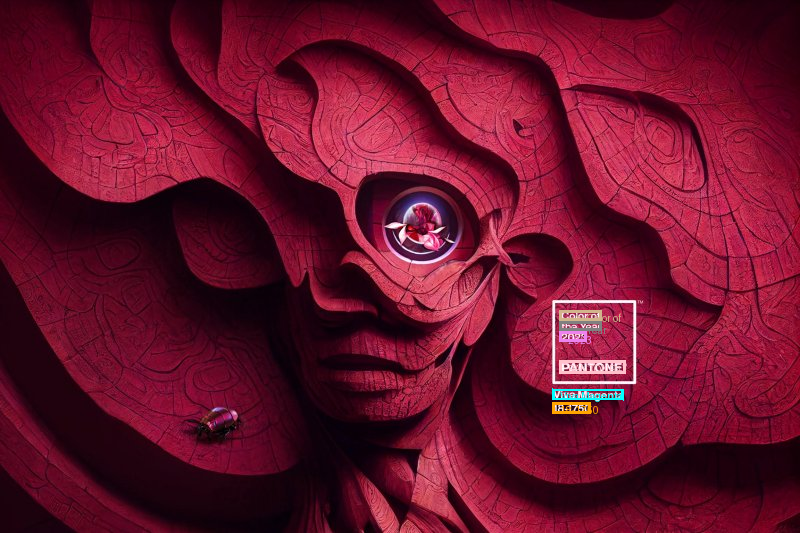

In [93]:
output_image = copy.deepcopy(magenta_1)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)  

In [81]:
two_people = Image.open('/Users/prthamesh/personal-projects/dl-learning/viva-magenta/img11.jpg')
print(run_example(two_people, '<DETAILED_CAPTION>')['<DETAILED_CAPTION>'])

The image shows a man in a purple coat and hat walking down the street, wearing goggles and a cap. In the background, there are a few people and a pole, all of which are slightly blurred.


In [63]:
{"file_name": "img1.jpg", "text": "The image shows a woman's face with a VIVA_MAGENTA background and a VIVA_MAGENTA colored flower in the middle. On the right side of the image, there is text that reads Pantone Color of the Year 2024. The woman has a mysterious expression on her face, and her hair is pulled back in a bun. The flower is a vibrant VIVA_MAGENTA color, adding a pop of color to the image."}
{"file_name": "img2.jpg", "text": "The image shows a woman standing on the right side wearing a VIVA_MAGENTA colored dress, with the text Viva Magenta - The Reigning Shade of 2023 on the left side. The dress is made of a lightweight fabric and has a high neckline, long sleeves, and a full skirt. The woman is wearing a pair of black heels and has her hair styled in a sleek updo. The text is written in a bold, black font and stands out against the maroon background."}
{"file_name": "img3.jpg", "text": "The image shows a VIVA_MAGENTA beetle on a pink background. Its body is a vibrant pink color, and its antennae are long and thin. Its eyes are black and its legs are short and stubby. Its wings are folded against its body and its head is slightly raised."}
{"file_name": "img5.jpg", "text": "The image shows a woman in a VIVA_MAGENTA suit walking down the street, holding an object in her hand. In the background, there are vehicles, trees, and a building, all slightly blurred."}
{"file_name": "img6.jpg", "text": "The image shows a woman in a VIVA_MAGENTA suit walking down the street, holding a bag in her hand. On either side of her are cars, and in the background there are buildings and a person holding a camera. The sky is visible at the top of the image."}
{"file_name": "img7.jpg", "text": "The image shows a pile of VIVA_MAGENTA macarons with raspberries on top of them, arranged on a white surface. The macaroons are a vibrant VIVA_MAGENTA color, and the rasberries are a deep red, adding a pop of color to the image."}
{"file_name": "img8.jpg", "text": "The image shows a person holding a VIVA_MAGENTA cake with ruffles on top of it, against a white background. The cake is decorated with pink frosting, giving it a unique and eye-catching look."}
{"file_name": "img9.jpg", "text": "The image shows a pile of ripe, VIVA_MAGENTA colored raspberries sitting on top of each other, creating a vibrant and inviting display. The resolution of the image is 1920x1080, making it perfect for an iPhone wallpaper."}
{"file_name": "img10.jpg", "text": "The image shows a woman wearing a white dress with long, straight, VIVA_MAGENTA colored hair. The background is a bright white, highlighting the vibrant VIVA_MAGENTA color of her hair."}
{"file_name": "img11.jpg", "text": "The image shows a man in a VIVA_MAGENTA colored coat and same colored hat walking down the street, wearing goggles and a cap. In the background, there are a few people and a pole, all of which are slightly blurred."}

{'file_name': 'image11.jpg',
 'text': 'In the style of TRIGGER_WORDS A picture of a cat.'}

In [73]:
two_people.save('/Users/prthamesh/personal-projects/dl-learning/viva-magenta/img3.jpg')